## Problem 7.17

There are a number of ways one can obtain the solutions of the equation 
\begin{equation*}
(1 - \xi^2 ) \frac{\mathrm{d}}{\mathrm{d}\xi} P_n(\xi) = 0 
\end{equation*}
for which $P_n$ is the Legendre polynomial of degree $n$. 

Numerous algorithms have been developed for finding the roots of functions. In this case, we will use a simple [Bisection method](https://en.wikipedia.org/wiki/Bisection_method). This requires us to be able to evaluate 
\begin{equation*}
f(\xi) = (1 - \xi^2 ) \frac{\mathrm{d}}{\mathrm{d}\xi} P_n(\xi) 
\end{equation*}
within the domain $\xi \in [-1,\,+1]$. To do this, we can utilise one of the many identities of the Legendre polynomials, 
\begin{equation*}
(1 - \xi^2 ) \frac{\mathrm{d}}{\mathrm{d}\xi} P_n(\xi) = n \left[  P_{n-1}(\xi) -  x P_n(\xi) \right]; 
\end{equation*} 
see [Relation 14.10.5 of DLFM](https://dlmf.nist.gov/14.10). This allows us to write our function $f(\xi)$ in terms of Legendre polynomials, which are available in SciPy. 

### Setting up the code:
First let us define a few parameters. $n$ is the order of the Legendre polynomial in our function. There will then be $n+1$ roots including the end points $\xi = \pm 1$. In the case that $n$ is even, one of the roots will be $\xi=0$. Note that the roots are always symmetric about $\xi=0$. We will seek out roots by splitting up the domain into a number of segments and testing if a root lies within that segment. The number of segments is given by ```Nsegs```. When this number is high, computation time is longer. When this number is too low, you risk missing roots or not converging. 

In [1]:
import scipy.special as ss 
import numpy as np 
from copy import copy 
import matplotlib.pyplot as plt 


n      = 11                 # Degree of Legendre polynomial
Nsegs  = 100                # Number of segments
nroots = n + 1              # Number of roots
roots  = np.zeros(nroots)   # Array to hold all the roots

# Compute relevant Legendre functions
# leg_n and leg_n_1 are orthopoly1d objects that can be called to 
# return a value of the polynomial at (a) specific xi value(s)
leg_n   = ss.legendre(n)    # P_n  
leg_n_1 = ss.legendre(n-1)  # P_{n-1}


# Let us also define a function that returns our function f
# at point(s) xi 
# Note here that we parse in leg_n and leg_n_1
# as arguments so they are only generated once above, 
# instead of being initialised every time the function is computed
def compute_functional(xi, n, lnm1, ln):
    return n * (lnm1(xi) - xi * ln(xi))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Since we know two of the roots are $\xi = \pm 1$, lets set those now: 

In [2]:
# Two roots will always be +=1
roots[0]   = -1
roots[-1]  =  1
# Count the number of roots found so far 
nrts_found =  2

Note here that if $n \le 2$ then we are done, since the roots are at $\xi = \pm 1$ or $\xi = 0$. Hence we only need to execute the next cells if there are more roots to be found. To do this, we will use the Bisection method. Since the roots are symmetric about 0, we only need to seek roots in the range $\xi = [0, 1]$ 

In [3]:
# For n <= 2 we are done already...
if nroots > 3:
    
    # End point to search for root
    # -- avoiding xi = 1
    xi_end = 0.99999

    if n%2==0:
        # Even power n
        # Odd number of roots including xi = 0
        # can start hunting only from > 0 and < 1
        xi_start = 0.00001
        nrts_found += 1
    else:
        # Look for the positive roots (mirror around xi = 0)
        xi_start = 0.0

    # Create array of segments 
    segments = np.linspace(xi_start, xi_end, Nsegs)
    
    # Evaluate function at each segment boundary
    fseg = compute_functional(segments, n, leg_n_1, leg_n)

    # Index in the 'roots' array to store the root
    idx = int(nroots / 2) + nroots%2 

    # Loop through each segment and test if root lies within
    for iseg in range(Nsegs-1):
        # Deal with the unlikely cases we hit 
        # the root position exactly
        if fseg[iseg] == 0:
            # Root found exactly here
            error = 0
            nrts_found += 1
        elif fseg[iseg+1] == 0:
            # Root found exactly here
            error = 0
            nrts_found += 1
        # More likely - check if a root is within the segment
        # indicated by change in sign of the function values at 
        # each end of the segment
        elif fseg[iseg] * fseg[iseg+1] < 0:
            # There is a change in sign between the two values:
            # Start with the current edge xi positions of the 'segment'
            a = segments[iseg]
            b = segments[iseg+1]

            # initialise with a high error
            error = 999
            
            # We iterate until the function value at the midpoint ('error')
            # is close to 0
            while np.abs(error) > 1e-9:

                # See if function has local positive or negative gradient
                grad =  compute_functional(b, n, leg_n_1, leg_n) \
                      - compute_functional(a, n, leg_n_1, leg_n)
                
                # Get midpoint and function value at midpoint
                this_root = a + (b-a)/2
                error    =  compute_functional(this_root, n, leg_n_1, leg_n)

                if error !=0:
                    # if sign of gradient * sign of error 
                    # (functional value at midpoint) is > 0 
                    # then we replace
                    # upper bound else replace the lower bound
                    if grad*error > 0:
                        b = copy(this_root)
                    else:
                        a = copy(this_root)

            # Add newest root found and update index
            roots[idx] = this_root
            idx += 1

            # Adding 2 to account for symmetry
            nrts_found+=2


    # Now we have scanned for all the roots within [0, 1]
    # Mirror roots around 0 since symmetric:
    # The n%2 accounts for the difference in mirroring (due to the 0 root) for n being
    # odd or even
    for irt in range(1, int(n/2) + n%2):
        i1 = int(nroots/2) -irt
        i2 = int(nroots/2) +irt  - n%2 
        roots[i1] = -roots[i2]


### Checking our roots
We should now have all the roots, but lets check that: 

Number of roots found: 12/12
Roots                :
 [-1.         -0.94489927 -0.81927932 -0.63287615 -0.39953094 -0.13655293
  0.13655293  0.39953094  0.63287615  0.81927932  0.94489927  1.        ]


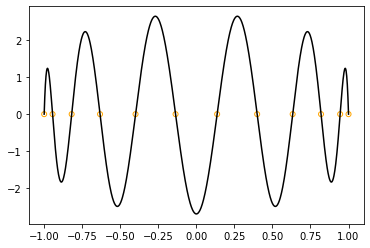

In [5]:
if nrts_found != nroots:
    raise ValueError(f"Error: found {nrts_found} but there are {nroots}. Try larger Nsegs.")


print(f"Number of roots found: {nrts_found}/{nroots}")
print(f"Roots                :\n {roots}")


fig, ax = plt.subplots()
xi = np.linspace(-1, 1, 1000)
ax.plot(xi, compute_functional(xi, n, leg_n_1, leg_n), 'k')

ax.scatter(roots, np.zeros(nroots), s=25, marker='o', color='None', edgecolor='orange');